In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Purposes of Data Exploration

## The general idea of exploring the data is to gain a better understanding of the data itself.
* Are there any patterns in the data I can see?
* Are there any problematic datapoints that may effect my training?
* Can I visualise my data in a meaningful way that will give me a deeper understanding of it?

These are the kinds of questions that will be answered as part of this section


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

## 1. Load the dataset

In [3]:
# Load data into pandas dataframe
data = pd.read_csv('/content/drive/MyDrive/final year/btc_tx_anomaly_detection/data/cleaned_undersampled_data.csv', index_col=False)
labels = data['is_fraud']

## 2. Explore the dataset

In [4]:
data.describe()

,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,is_fraud,vin_sz,vout_sz,size,fee,time,sat_per_byte
count,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000,11325.000000
mean,0.002016,0.002035,0.002026,0.001517,0.002174,0.009536,0.002582,0.002077,0.005500,0.001059,0.778853,0.004661
std,0.021633,0.021457,0.021532,0.018954,0.022701,0.097192,0.019061,0.021050,0.027023,0.013033,0.186413,0.015876
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000002,0.000003,0.000003,0.000001,0.000003,0.000000,0.000000,0.000361,0.001220,0.000103,0.699522,0.000533
50%,0.000021,0.000029,0.000031,0.000012,0.000029,0.000000,0.000000,0.000361,0.001543,0.000515,0.821617,0.002941
75%,0.000212,0.000340,0.000334,0.000155,0.000324,0.000000,0.001880,0.000361,0.003419,0.000515,0.917670,0.005661
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Data Distribution

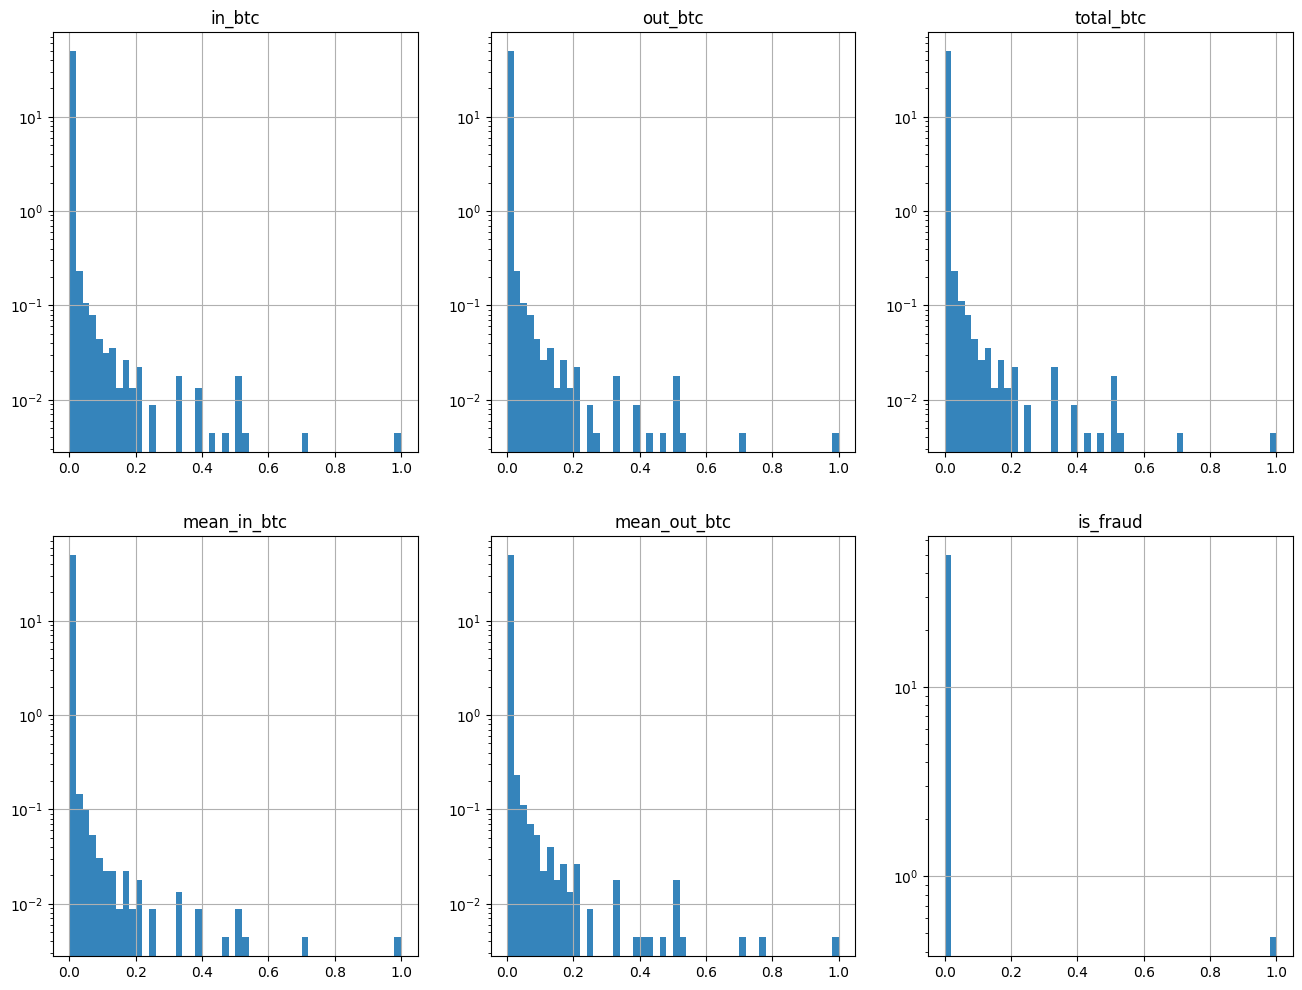

In [25]:
count = 0;
bins = 50
fig, ax = plt.subplots(2,3, figsize=(16,12))
for i in range(2):
  for j in range(3):
    ax[i][j].hist(data.iloc[:,count], bins=bins, alpha=0.9, log=True, density=True)
    ax[i][j].title.set_text(data.columns[count])
    ax[i][j].grid()
    count+=1
plt.show()

As we can see, the data is skewed towards smaller values. This means there are few data points that have a high value for each feature.

A naive way of detecting anomalies would be to set a threshold, say at 0.6. Anything above that can be flagged as a fraudulent transaction.

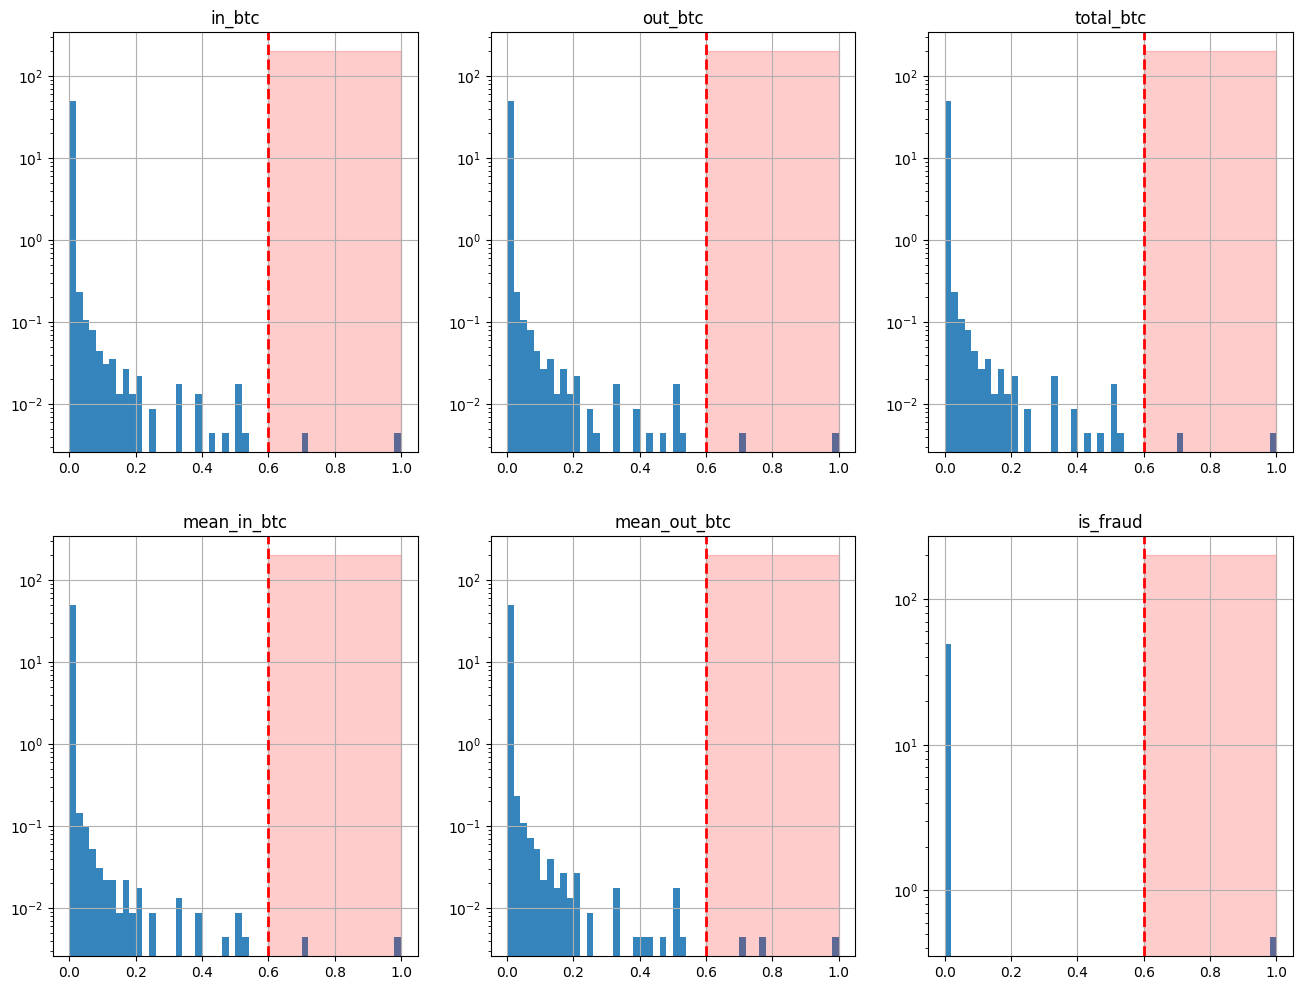

In [27]:
count = 0;
bins = 50
fig, ax = plt.subplots(2,3, figsize=(16,12))
for i in range(2):
  for j in range(3):
    data_values = data.iloc[:, count]
    ax[i][j].hist(data.iloc[:,count], bins=bins, alpha=0.9, log=True, density=True)
    ax[i][j].title.set_text(data.columns[count])
    ax[i][j].grid()

    ax[i][j].axvline(x=0.6, color='red', linestyle='--', linewidth=2)
    ax[i][j].fill_betweenx(np.linspace(0, 100), 0.6, 1, color='red', alpha=0.2)

    count+=1
plt.show()

Without knowing more about the data, this could lead to a lot of issues

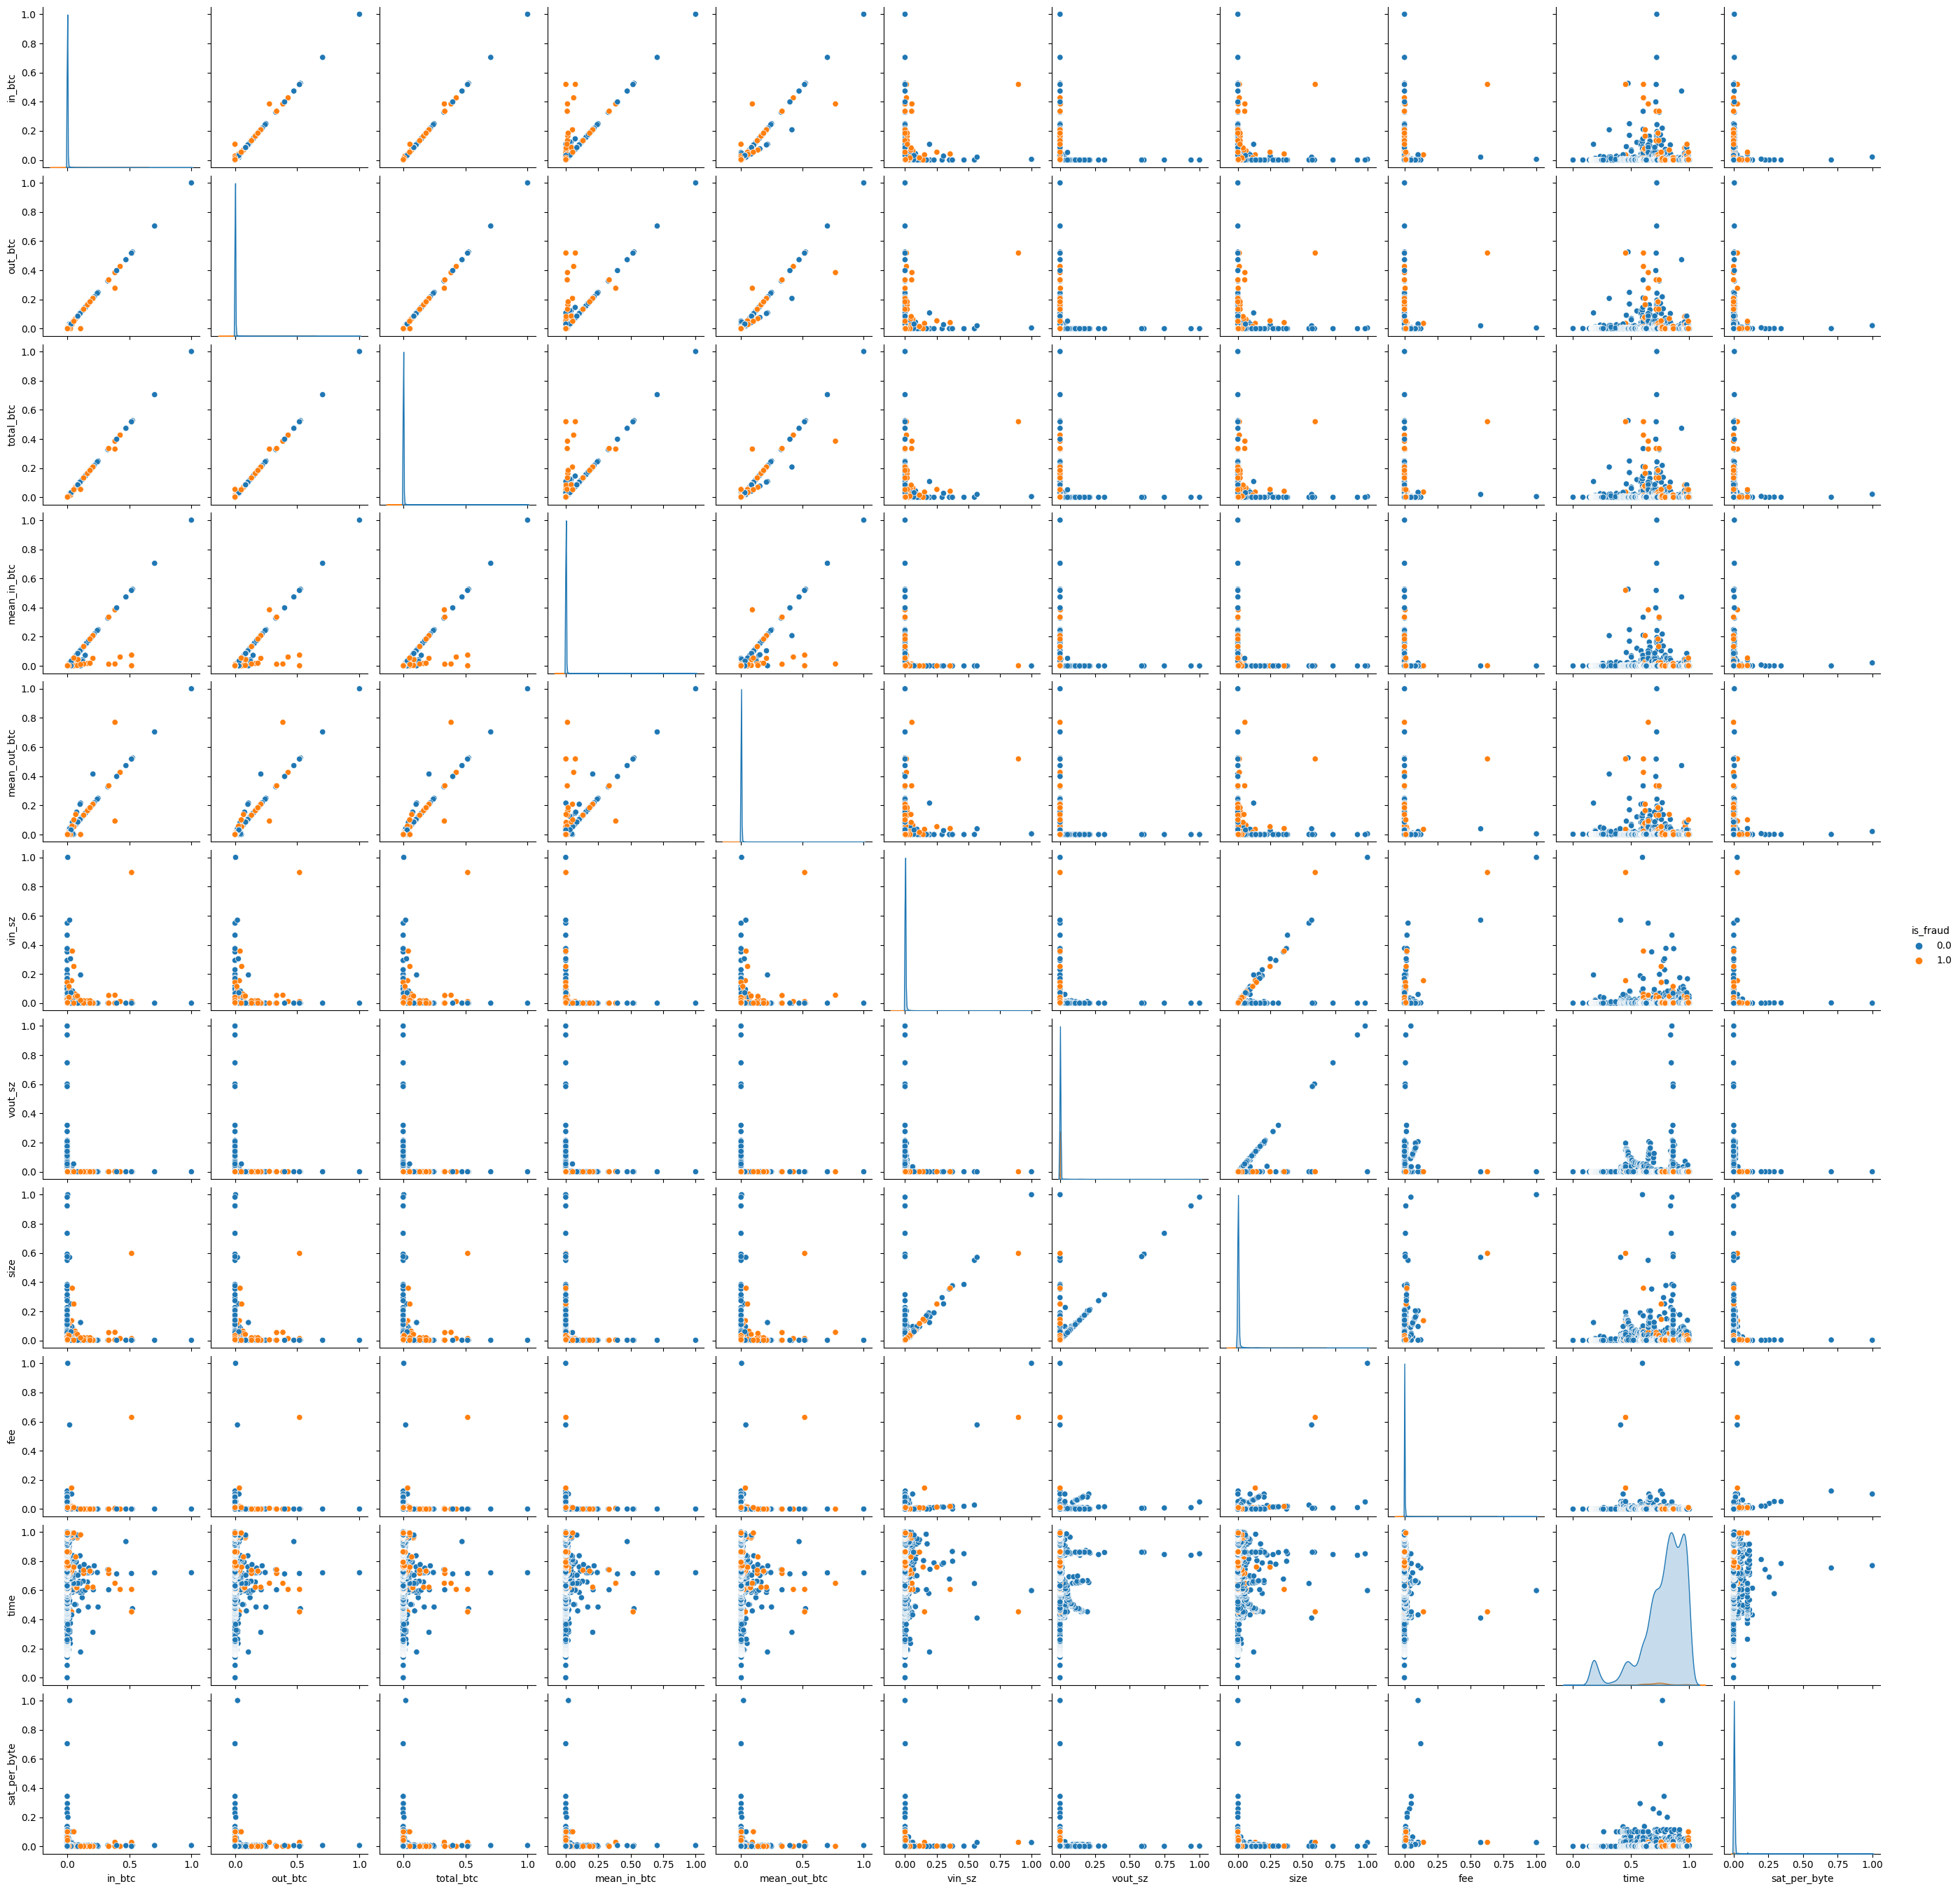

In [ ]:
sns.pairplot(data, hue='is_fraud')

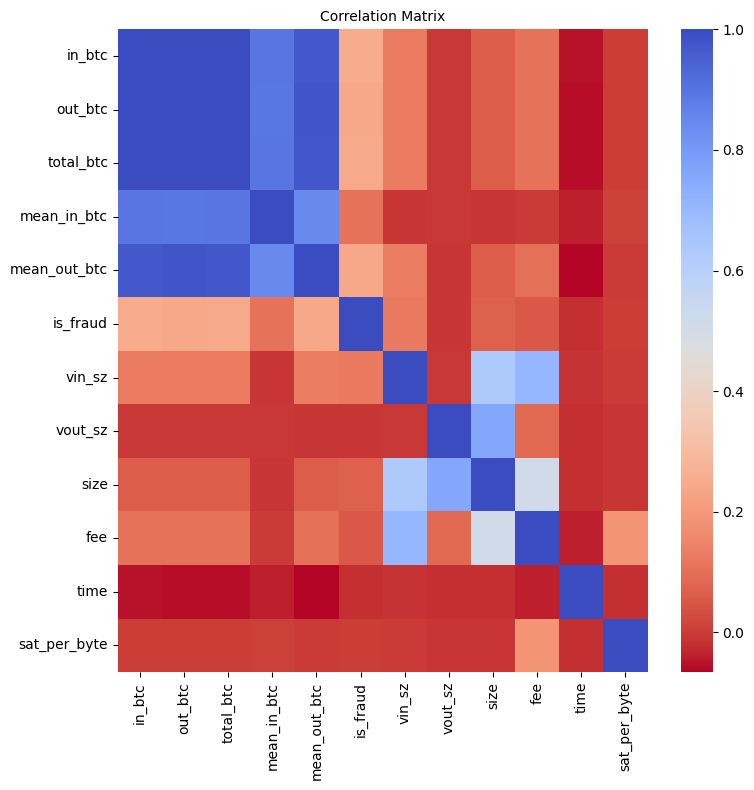

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

# correlation
corr = data.corr()

# Plot the entire DataFrame correlation matrix
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size': 20}, ax=ax)
ax.set_title("Correlation Matrix", fontsize=10)

plt.tight_layout()
plt.show()


# Using Dimentionality reduction to visualise the data in a 3d or 2d feature space

To give us a better idea of how are data points are scattered in the feature space, we can use some techniques to reduce the dimentionality of the data.

Although this will allow us to visually represent the data in a way that makes it easier for us to understand, it's important to note that when we reduce the dimensionality of our data, we will *loose* some information. This means that what we end up viewing may not be indicitive of the actual data.

After some research, I decide to use UMAP (Uniform Manifold Approximation) technique for dimensionality reduction because it is said to loose less information and therefore can give a better representation of the data

Inspiration for this: https://www.youtube.com/watch?v=015vL0cJfA0

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=d0df95bcf042b1b2114ad7e0d388ddcbcb10cf5b143f86d9dd61e6fded125157
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
from umap import UMAP

features = data.drop(['is_fraud'], axis=1).values

# define umap
umap_2d = UMAP(n_components=2, init='random', random_state=42)
umap_3d = UMAP(n_components=3, init='random', random_state=42)

# reduce dimensions
proj_2d = umap_2d.fit_transform(features)
proj_3d = umap_3d.fit_transform(features)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
proj_3d.shape

(11325, 3)

In [ ]:
import plotly.express as px

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=labels,
    labels=labels
)

fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=labels,
    labels=labels
)

fig_2d.show()
fig_3d.show()

# Reducing Dimensionality using Autoencoders

Autoencoders can also be used to reduce the dimensionality of our data. Since the encoder will be reducing the dimension into a latent space, we can use this data in this latent representation and visualise it.

In [ ]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

X = data.drop('is_fraud', axis=1)
y = labels

# Split into training, validation and test data
# Stratify to get even distribution of classes in the training and test data
# This is useful because we have an uneven class proprtion (far fewer fraudulent transactions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42, stratify=y)

# Create validation set as 15% of orginal dataset (not 10% of X_train which would be 10% of 80%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test)

# Reduce to 3D and 2D to visualise distribution


## Reduce to 3D

In [ ]:
input_dim, output_dim = 11, 11
latent_dim = 3

encoder = keras.models.Sequential([
    keras.layers.Dense(200, input_shape=(input_dim, )),
    keras.layers.Dense(140,activation='selu'),
    keras.layers.Dense(80,activation='selu'),
    keras.layers.Dense(16,activation='selu'),
    keras.layers.Dense(8,activation='selu'),
    keras.layers.Dense(latent_dim)
])

decoder = keras.models.Sequential([
  keras.layers.Dense(8, input_shape=(latent_dim, )),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dense(80,activation='relu'),
    keras.layers.Dense(140,activation='relu'),
    keras.layers.Dense(200,activation='relu'),
    keras.layers.Dense(input_dim)
])

Autoencoder = keras.models.Sequential([encoder, decoder])

Autoencoder.compile(loss='mse',
                    optimizer=keras.optimizers.SGD())

Autoencoder.fit(X_train, X_train, validation_data=[X_val, X_val], epochs=50)

# fit using encoder only
y_pred_3d = encoder.predict(X_test)

Epoch 1/50
284/284 [==============================] - 3s 5ms/step - loss: 0.0245 - val_loss: 0.0062
Epoch 2/50
284/284 [==============================] - 1s 4ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 3/50
284/284 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/50
284/284 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/50
284/284 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/50
284/284 [==============================] - 2s 6ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7/50
284/284 [==============================] - 1s 5ms/step - loss: 9.3021e-04 - val_loss: 0.0011
Epoch 8/50
284/284 [==============================] - 1s 5ms/step - loss: 8.4979e-04 - val_loss: 0.0010
Epoch 9/50
284/284 [==============================] - 1s 5ms/step - loss: 7.8704e-04 - val_loss: 9.4232e-04
Epoch 10/50
284/284 [==============================] - 1s 5ms/step - loss: 7.3633e-0

## Visualise 3D scatter

In [ ]:
fig_3d_autoencoder = px.scatter_3d(
    y_pred_3d, x=0, y=1, z=2,
    color=y_test,
    labels=y_test
)

fig_3d.show()

## Reduce to 2D

In [ ]:
input_dim, output_dim = 11, 11
latent_dim = 3

encoder_v2 = keras.models.Sequential([
    keras.layers.Dense(200, input_shape=(input_dim, )),
    keras.layers.Dense(140,activation='selu'),
    keras.layers.Dense(80,activation='selu'),
    keras.layers.Dense(16,activation='selu'),
    keras.layers.Dense(8,activation='selu'),
    keras.layers.Dense(latent_dim)
])

decoder_v2 = keras.models.Sequential([
  keras.layers.Dense(8, input_shape=(latent_dim, )),
    keras.layers.Dense(16,activation='selu'),
    keras.layers.Dense(80,activation='selu'),
    keras.layers.Dense(140,activation='selu'),
    keras.layers.Dense(200,activation='selu'),
    keras.layers.Dense(output_dim)
])

Autoencoder_v2 = keras.models.Sequential([encoder_v2, decoder_v2])

Autoencoder_v2.compile(loss='mse',
                    optimizer=keras.optimizers.SGD())
Autoencoder_v2.fit(X_train, X_train, validation_data=[X_val, X_val], epochs=50)

# predict
y_pred_2d = encoder_v2.predict(X_test)

Epoch 1/50
284/284 [==============================] - 6s 13ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 2/50
284/284 [==============================] - 2s 8ms/step - loss: 0.0012 - val_loss: 9.5378e-04
Epoch 3/50
284/284 [==============================] - 2s 6ms/step - loss: 7.6584e-04 - val_loss: 8.0653e-04
Epoch 4/50
284/284 [==============================] - 2s 8ms/step - loss: 6.4306e-04 - val_loss: 0.0012
Epoch 5/50
284/284 [==============================] - 2s 6ms/step - loss: 5.6991e-04 - val_loss: 6.8482e-04
Epoch 6/50
284/284 [==============================] - 3s 9ms/step - loss: 5.1317e-04 - val_loss: 6.5375e-04
Epoch 7/50
284/284 [==============================] - 2s 7ms/step - loss: 4.7590e-04 - val_loss: 6.1144e-04
Epoch 8/50
284/284 [==============================] - 3s 9ms/step - loss: 4.4656e-04 - val_loss: 5.9142e-04
Epoch 9/50
284/284 [==============================] - 3s 11ms/step - loss: 4.2371e-04 - val_loss: 5.8028e-04
Epoch 10/50
284/284 [=====================

## Visualise 2D scatter

In [ ]:
fig_2d_autoencoder = px.scatter(
    proj_2d, x=0, y=1,
    color=labels,
    labels=labels
)

fig_2d_autoencoder.show()

# Conclusions

There is no clear separation between legitimate transactions and fraudulent transactions within the feature space, with fraudulent transactions denoted in yellow, are intertwined with legitimate transcations in the feature space.

This means it may prove difficult to perform a binary classification on the data or use other algorithms that rely on drawing a decision boundary between the data.

However it is worth noting that we can observe that although the fraud transactions are embedded within a group of legit transactions, there does seem to be some level of clustering. This could be due to the fact that the dataset has been gathered from another dataset, which actually categorised fraud or malicious transactions into those from:
- thefts
- hacks
- lost
- seizures
- and miscelaneous

With some clustering algorithms such as dbscan or isolation forest, we may be able to find these fraudulent transactions within these clusters (although it is to be seen whether the dimentionality of the data will make this difficult).